In [ ]:
!wget -q https://raw.githubusercontent.com/openforcefield/2023-workshop-vignettes/main/colab_setup.ipynb
%run colab_setup.ipynb

In [ ]:
%env LD_LIBRARY_PATH=$LD_LIBRARY_PATH:$CONDA_PREFIX/lib/

In [1]:
from utils import draw_molecule, AtomHighlight

from openff.toolkit import ForceField, Molecule
from openff.units import unit

In [2]:
def get_bond_lengths(
    molecule: str,
    force_field: ForceField = ForceField("openff-2.1.0.offxml"),
) -> dict[tuple[int], str]:
    bond_lengths: dict[tuple[int], float] = dict()
    bond_collection = force_field.create_interchange(
        topology=Molecule.from_smiles(molecule).to_topology(),
    )["Bonds"]

    for topology_key, potential_key in bond_collection.key_map.items():
        potential = bond_collection.potentials[potential_key]

        length = potential.parameters["length"].m_as(unit.angstrom)
        bond_lengths[topology_key.atom_indices] = f"{length:.2f} Å"

    return bond_lengths

def get_lj_highlights(
    molecule: str,
    force_field: ForceField = ForceField("openff-2.1.0.offxml"),
) -> dict[tuple[int], str]:
    vdw_params: dict[int, (Quantity, Quantity)] = dict()
    vdw_collection = force_field.create_interchange(
        topology=Molecule.from_smiles(molecule).to_topology(),
    )["vdW"]

    for topology_key, potential_key in vdw_collection.key_map.items():
        potential = vdw_collection.potentials[potential_key]

        rmin_half = 2**(1/6) * potential.parameters["sigma"] / 2
        epsilon = potential.parameters["epsilon"]
        
        vdw_params[topology_key.atom_indices[0]] = (rmin_half, epsilon)
    
    vdw_handler = force_field["vdW"]
    max_epsilon = max([param.epsilon for param in vdw_handler.parameters])
    highlights = {
        i: AtomHighlight(
            radius=rmin_half,
            color = (0, 200, epsilon / max_epsilon * 255)
        ) for i, (rmin_half, epsilon) in vdw_params.items()
    }

    return highlights

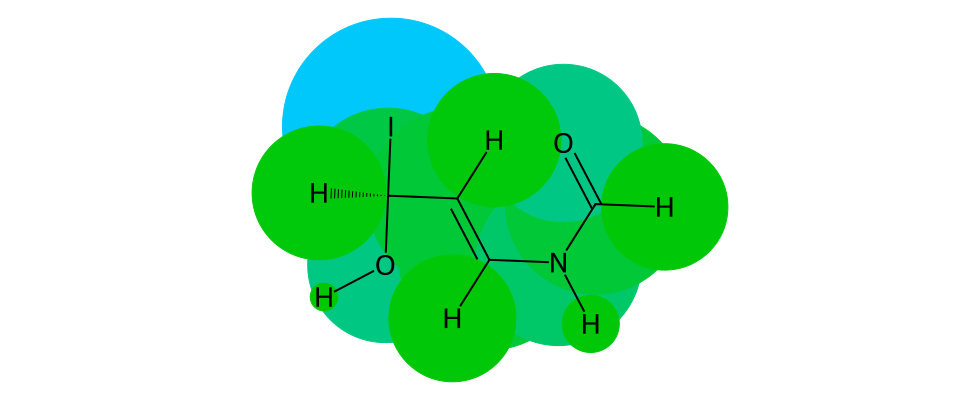

In [3]:
SMILES = r"[I][C@H](O)/C=C/NC=O"
draw_molecule(SMILES, highlight_atoms=get_lj_highlights(SMILES))

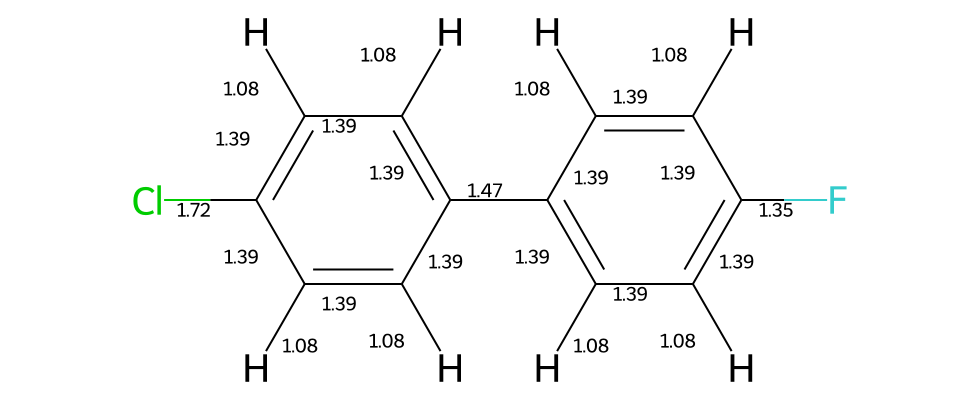

In [4]:
SMILES = r"C1=CC(=CC=C1C2=CC=C(C=C2)F)Cl"

draw_molecule(SMILES, bond_notes=get_bond_lengths(SMILES))

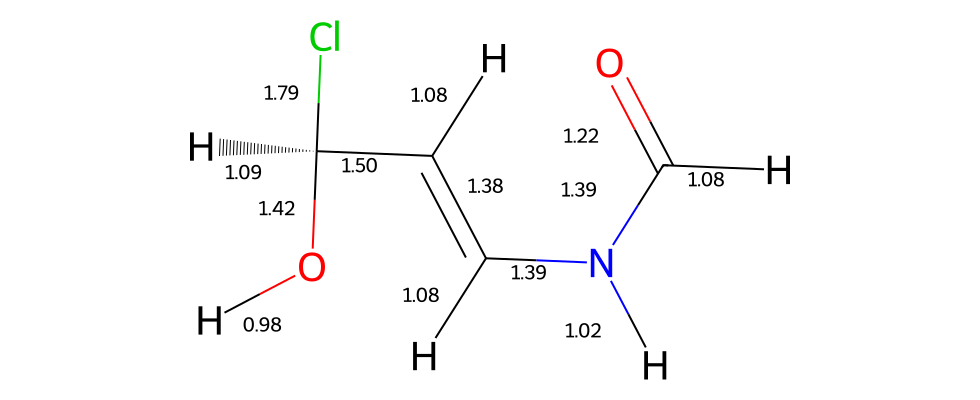

In [5]:
SMILES = r"[Cl][C@H](O)/C=C/NC=O"
draw_molecule(SMILES, bond_notes=get_bond_lengths(SMILES))